# Algorithm for Trading

## Technical tools project :
-  ### Trend detection
-  ### Psychologic threshold 

## Disclaimer: 
Plotly interactive graphs are not supported by github due to the interface and project size limit, so each ‘plot_trend’ function call is commented followed by a screenshot of the rendering. 


I invite you to download the notbook locally and try it out for yourself by uncommenting the Plotly graphs. You can test any period and even other assets if you have the necessary data. 

Thank you for your understanding

## I. Data preparation

In [27]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image, display



#### Definition of dynamic course study periods according to dates

In [2]:
BNB_USDT=pd.read_csv('BNBUSDT_1h_20171106_20250328.csv')
BNB_USDT['open_time']=pd.to_datetime(BNB_USDT['open_time'])
BNB_USDT['close_time']=pd.to_datetime(BNB_USDT['close_time'])
BNB_USDT_zoom=BNB_USDT[(BNB_USDT['open_time'].dt.year==2024)]
BNB_USDT_zoom_week = BNB_USDT[
    (BNB_USDT['open_time'] >= '2021-10-03') & 
    (BNB_USDT['open_time'] < '2022-04-30')
]
BNB_USDT_zoom_week['timestamp'] = BNB_USDT_zoom_week['open_time'].view('int64') // 10**11
BNB_USDT_zoom_week=BNB_USDT_zoom_week.reset_index()

BNB_USDT_zoom_week.head()

,index,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,symbol,timestamp
0,34124,2021-10-03 00:00:00,427.0,434.0,421.5,424.1,76338.675,2021-10-03 00:59:59,3.265592e+07,41858,35058.975,1.500440e+07,BNBUSDT,16332192
1,34125,2021-10-03 01:00:00,424.1,428.0,423.0,425.4,45529.814,2021-10-03 01:59:59,1.936317e+07,27599,21905.369,9.317400e+06,BNBUSDT,16332228
2,34126,2021-10-03 02:00:00,425.4,429.9,424.2,426.3,34666.935,2021-10-03 02:59:59,1.480647e+07,24712,17520.079,7.482938e+06,BNBUSDT,16332264
3,34127,2021-10-03 03:00:00,426.3,429.8,424.8,429.7,23436.178,2021-10-03 03:59:59,1.000444e+07,14501,12442.150,5.312752e+06,BNBUSDT,16332300
4,34128,2021-10-03 04:00:00,429.7,430.9,428.2,429.0,21449.370,2021-10-03 04:59:59,9.210723e+06,13949,10892.043,4.677010e+06,BNBUSDT,16332336


#### Data visualization with matplotlib 

Text(0.5, 1.0, 'BNB_USDT')

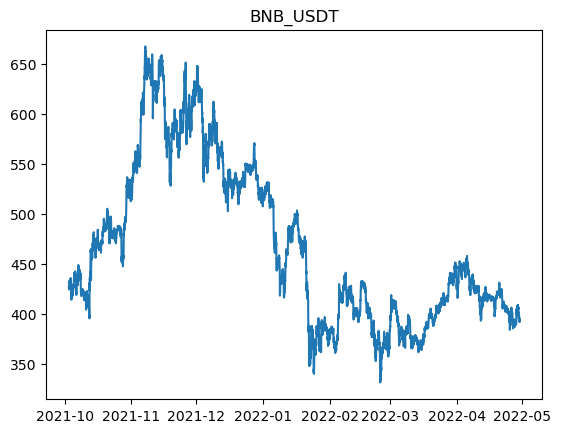

In [3]:
plt.plot (BNB_USDT_zoom_week['open_time'], BNB_USDT_zoom_week['open'])
plt.title('BNB_USDT')

#### Data visualization with plotly 

In [56]:
def plot_candlesticks(df, title="Candlestick chart"):
   
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )
    fig.show()

#plot_candlesticks(BNB_USDT_zoom_week)

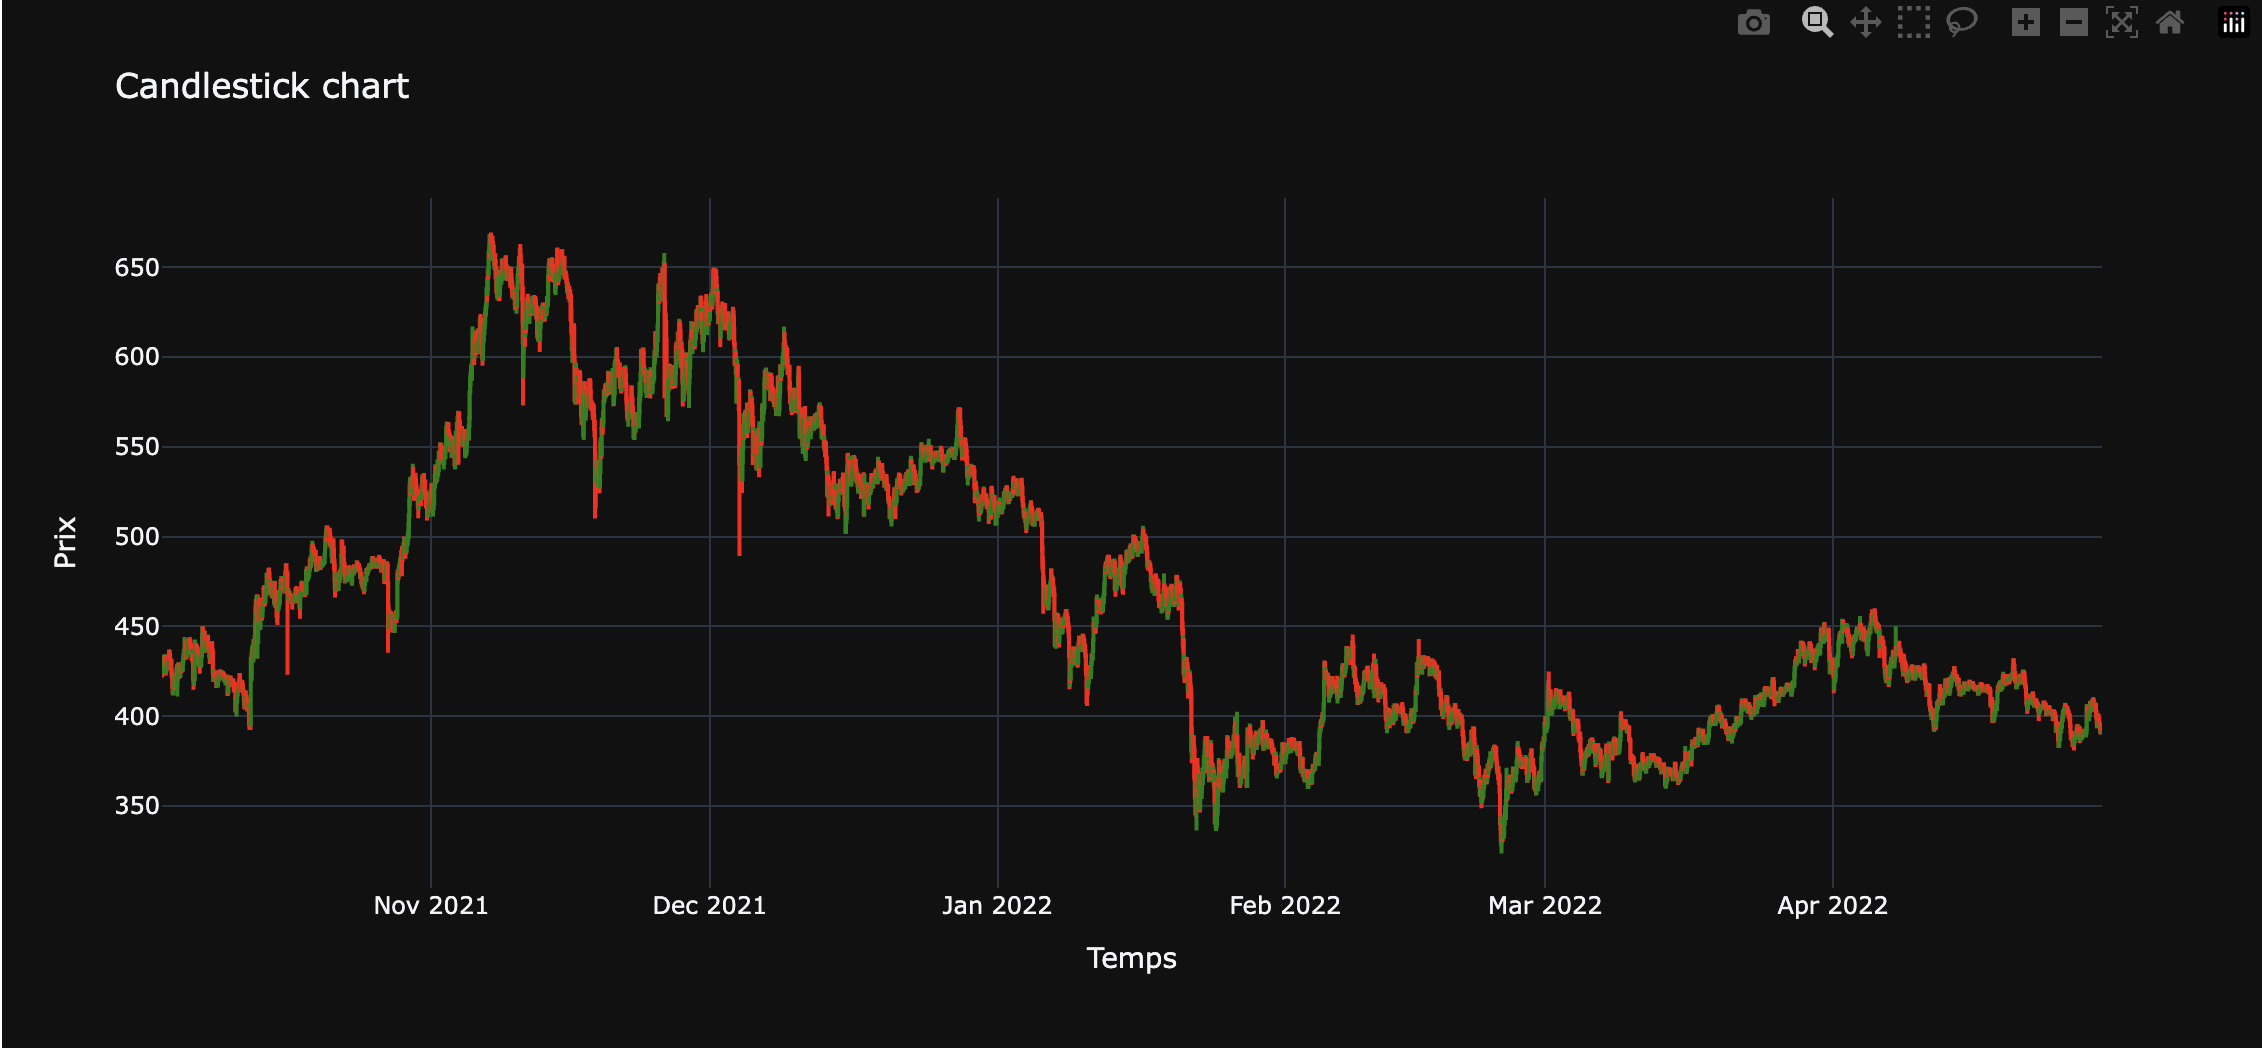

In [41]:
# La bibliothèque plotly n'est pas supporté par github voici donc des screenshot des résultats 
display(Image(filename="candlestick.jpeg"))

## II. Detracting from the latest trend : 

### Methodology : 
-  Calculation of moving averages for each selected time period
-  Detection of the last reversal in the direction of variation of the moving average
-  Delimitation of the working area 
-  Definition of trend resistance in the working area
-  Definition of support for the trend in the working area
-  Implementation of support and resistance in the data set for data visualization 

### Definition of study period size : 
-  Moving average over a given period 
-  Moving maximum peak within a given period 
-  Minimum moving peak for a given period 

In [5]:
moyenne_mobile=[]
BNB_USDT_zoom_week['periode']=BNB_USDT_zoom_week['open_time'].dt.floor('200H') 
moyenne_mobile=BNB_USDT_zoom_week.groupby('periode')['open'].mean()
min_mobile=BNB_USDT_zoom_week.groupby('periode')['low'].min()
max_mobile=BNB_USDT_zoom_week.groupby('periode')['high'].max()

### Definition of the last price trend by : 

-  find_trend_index :    Detects the last sequence of consecutive variations (same sign) in the series and returns its starting point and length.

-  find_trend :   Extracts the sub-series corresponding to the last trend detected in the moving average, with its associated max/min.
-  calc_line_params :    Calculate the coefficients a and b of the line passing through two points (y = ax + b).
-  distance_to_line :     Calculate the vertical distance between a point (x, y) and the line y = ax + b.
-  fit_resistance_from_maxima :  Attempts to fit a resistance line to a series of maxima, with a tolerance on overshoots.
-  fit_support_from_minimum :  Tries to fit a support line to a series of minima, tolerating slight negative deviations.
-  define_resistance :  Builds a resistance line between two local peaks detected in the price data.

-  define_support :  Builds a support line between two local troughs detected in the price data.

In [6]:
def find_trend_index (moyenne_mobile) : 

    for i in range(1, len(moyenne_mobile)+1):
        sign = np.sign(moyenne_mobile[-i])        # On récupère le signe de la variation de al moyenne mobile du plus récent au plus antérieur
        count=0
        for j in range(len(moyenne_mobile)-i) :
            tmp=0
            if np.sign(moyenne_mobile[-1-i-j])==sign : # On remonte dans la série pour compter combien de variations ont ce même signe
                count+=1
            elif (tmp==0) and (abs(-2-i-j)<=len(moyenne_mobile)) :  # si le signe est différent on test la moyenne mobile suivante comme une "tolérance"
                if np.sign(moyenne_mobile[-2-i-j])==sign :          # si pas de tolérance, on stoppe 
                    count+=1
                else :
                    break
            else :                      
                break
        if count>=2 :
            break 
    return len(moyenne_mobile)-(i), count+1

def find_trend(moyenne_mobile, max_mobile, min_mobile) : 
    index, frame=find_trend_index (moyenne_mobile.diff())
    if frame<2 : 
        raise ValueError("Il faut au moins 3 période pour une tendance.")
    
    # On extrait la portion de tendance sur les 3 séries : moyenne, maximums et minimums
    moyenne_mobile=moyenne_mobile[index-frame:index+1]
    max_mobile=max_mobile[index-frame:index+1]
    min_mobile=min_mobile[index-frame:index+1]  

    #model_supp = TheilSenRegressor()
    #model_supp.fit(np.arange(len(min_mobile)).reshape(-1, 1), min_mobile.values)
    #x_support = model_supp.coef_  
    #y_support = model_supp.intercept_

    #model_res = TheilSenRegressor()
    #model_res.fit(np.arange(len(max_mobile)).reshape(-1, 1), max_mobile.values)
    #x_res = model_res.coef_  
    #y_res = model_res.intercept_
    
    return  moyenne_mobile, max_mobile, min_mobile, frame, index


In [7]:
def calc_line_params(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1) if x2 != x1 else 0
    b = y1 - a * x1
    return a, b

def distance_to_line(a, b, x, y):
    return y - (a * x + b)

def fit_resistance_from_maxima(max_series, close_series=None, tolerance=0.01):
    if len(max_series) < 2:
        raise ValueError("Il faut au moins deux points pour tracer une droite.")

    max_series = max_series.dropna()
    dates = max_series.index
    y = max_series.values
    x = np.arange(len(y))

    def check_fit_resistance(x1_idx, x2_idx):
        a, b = calc_line_params(x[x1_idx], y[x1_idx], x[x2_idx], y[x2_idx])
        n_points = 2
        n_touches = 0
        max_dist = 0

        for i in range(len(x)):
            if i in (x1_idx, x2_idx):
                continue
            y_line = a * x[i] + b
            delta = y[i] - y_line

            if delta > y_line * tolerance:   # point trop au-dessus
                return None  
            elif abs(delta) <= y_line * tolerance:
                n_touches += 1
            else:
                max_dist = np.maximum(max_dist, abs(delta))

        return {
            'a': a,
            'b': b,
            'touches': n_touches + n_points,
            'max_dist': max_dist,
            'x1_idx': x1_idx,
            'x2_idx': x2_idx
        }
    for start_idx in range(len(x) - 2):  # on s'arrête pour garder au moins 3 points
        result = check_fit_resistance(start_idx, len(x) - 1)
        if result:
            sub_series = max_series.iloc[result['x1_idx']:result['x2_idx'] + 1]
            return result['a'], result['b'], sub_series
    
    raise ValueError("Impossible de trouver une résistance valide selon les critères donnés.")

def fit_support_from_minimum(min_series, close_series=None, tolerance=0.01):
    if len(min_series) < 2:
        raise ValueError("Il faut au moins deux points pour tracer une droite.")

    min_series = min_series.dropna()
    dates = min_series.index
    y = min_series.values
    x = np.arange(len(y))

    def check_fit_support(x1_idx, x2_idx):
        a, b = calc_line_params(x[x1_idx], y[x1_idx], x[x2_idx], y[x2_idx])
        n_points = 2
        n_touches = 0
        max_dist = 0

        for i in range(len(x)):
            if i in (x1_idx, x2_idx):
                continue
            y_line = a * x[i] + b
            delta = y[i] - y_line

            if delta < -abs(y_line * tolerance): # point trop en-dessous
                return None  

            elif abs(delta) <= abs(y_line * tolerance):
                n_touches += 1

            else:
                max_dist = np.maximum(max_dist, abs(delta))
        return {
            'a': a,
            'b': b,
            'touches': n_touches + n_points,
            'max_dist': max_dist,
            'x1_idx': x1_idx,
            'x2_idx': x2_idx
        }
    for start_idx in range(len(x) - 2):  # on s'arrête pour garder au moins 3 points
        result = check_fit_support(start_idx, len(x) - 1)
        if result:
            sub_series = min_series.iloc[result['x1_idx']:result['x2_idx'] + 1]
            return result['a'], result['b'], sub_series
    
    raise ValueError("Impossible de trouver une résistance valide selon les critères donnés.")

In [8]:
def define_resistance (new_max_mobile, df) : 

    # trouver l'indice du premier et dernier pique de la trend détecté
    target_start=new_max_mobile.index[0]
    start_index_resistance=df[(df['periode']==target_start) & (df['high']==new_max_mobile[0])].index[0]
    target_end=new_max_mobile.index[-1]
    end_index_resistance=df[(df['periode']==target_end) & (df['high']==new_max_mobile[-1])].index[0]
    
    #définir lles coordonnées du premier et dernier pique de la trend 
    x0 = start_index_resistance
    x1 = end_index_resistance
    y0 = new_max_mobile[0]
    y1 = new_max_mobile[-1]

    #définir la pente et l'intercepte de la résistance 
    a, b = calc_line_params(x0, y0, x1, y1)

    # on crée une series qui de meme taille que le data frame
    resistance = np.zeros(df.shape[0])

    # on place entre les indices du premier et dernier pique la résistance
    x_range = np.arange(x0, x1 + 1)
    resistance[x0:x1 + 1] = a * x_range + b

    return resistance

def define_support (new_min_mobile, df) : 

    # trouver l'indice du premier et dernier pique de la trend détecté
    target_start=new_min_mobile.index[0]
    start_index_support=df[(df['periode']==target_start) & (df['low']==new_min_mobile[0])].index[0]
    target_end=new_min_mobile.index[-1]
    end_index_support=df[(df['periode']==target_end) & (df['low']==new_min_mobile[-1])].index[0]
    
    #définir les coordonnées du premier et dernier pique de la trend 
    x0 = start_index_support
    x1 = end_index_support
    y0 = new_min_mobile[0]
    y1 = new_min_mobile[-1]

    #définir la pente et l'intercepte du support 
    a, b = calc_line_params(x0, y0, x1, y1)

    # on crée une series qui est de meme taille que le data frame
    support = np.zeros(df.shape[0])

    # on place entre les indices du premier et dernier pique le support
    x_range = np.arange(x0, x1 + 1)
    support[x0:x1 + 1] = a * x_range + b

    return support

##### Delimiting the work area 


In [9]:
# we retrieve all the useful information between the terminals of the identified period. 
moyenne, max, min, frame, index=find_trend(moyenne_mobile, max_mobile, min_mobile) 

##### Defining the resistance of the trend in the working area


In [10]:
# we recover the slope and the intercept of the resistance
a_resistance, b_resistance , new_max_mobile=fit_resistance_from_maxima(max)

##### Defining trend support in the work area

In [11]:
# we recover the slope and the intercept of the support
a_support, b_support , new_min_mobile=fit_support_from_minimum(min)

##### Implementation of support and resistance in the data set for Data Visualization 

In [12]:
BNB_USDT_zoom_week['resistance']=define_resistance(new_max_mobile, BNB_USDT_zoom_week)
BNB_USDT_zoom_week['resistance']=BNB_USDT_zoom_week['resistance'].replace(0.0, np.nan)

BNB_USDT_zoom_week['support']=define_support(new_min_mobile, BNB_USDT_zoom_week)
BNB_USDT_zoom_week['support']=BNB_USDT_zoom_week['support'].replace(0.0, np.nan)

### Results display : plot_trend

In [55]:
def plot_trend (df, threshold=None, max_peak=None, min_peak=None,title="Candlestick chart"):

   # Affichage des candlestck
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )

    # Affichage de la dernière tendance 
    fig.add_trace(go.Scatter(
    x=df['open_time'],
    y=df['resistance'],
    mode='lines',
    line=dict(color='orange', dash='dash'),
    name='Résistance'
    ))

    fig.add_trace(go.Scatter(
    x=df['open_time'],
    y=df['support'],
    mode='lines',
    line=dict(color='blue', dash='dash'),
    name='Résistance'
    ))

    # Affichage peak maximum si detecté
    if max_peak is not None and len(max_peak) > 0:
        fig.add_trace(go.Scatter(
        x=df.loc[max_peak, 'open_time'],
        y=df.loc[max_peak, 'high'],
        mode='markers',
        marker=dict(color='red', size=10),
        name='Peaks'
    ))
        
    # Affichage des candlestck
    if threshold!=None :
        for seuil in threshold :
            fig.add_hline(y=seuil[0], line=dict(color='green', dash='dash'), annotation_text=f'Seuil {seuil[0]}', annotation_position='right')
    fig.show()

#plot_trend(BNB_USDT_zoom_week)

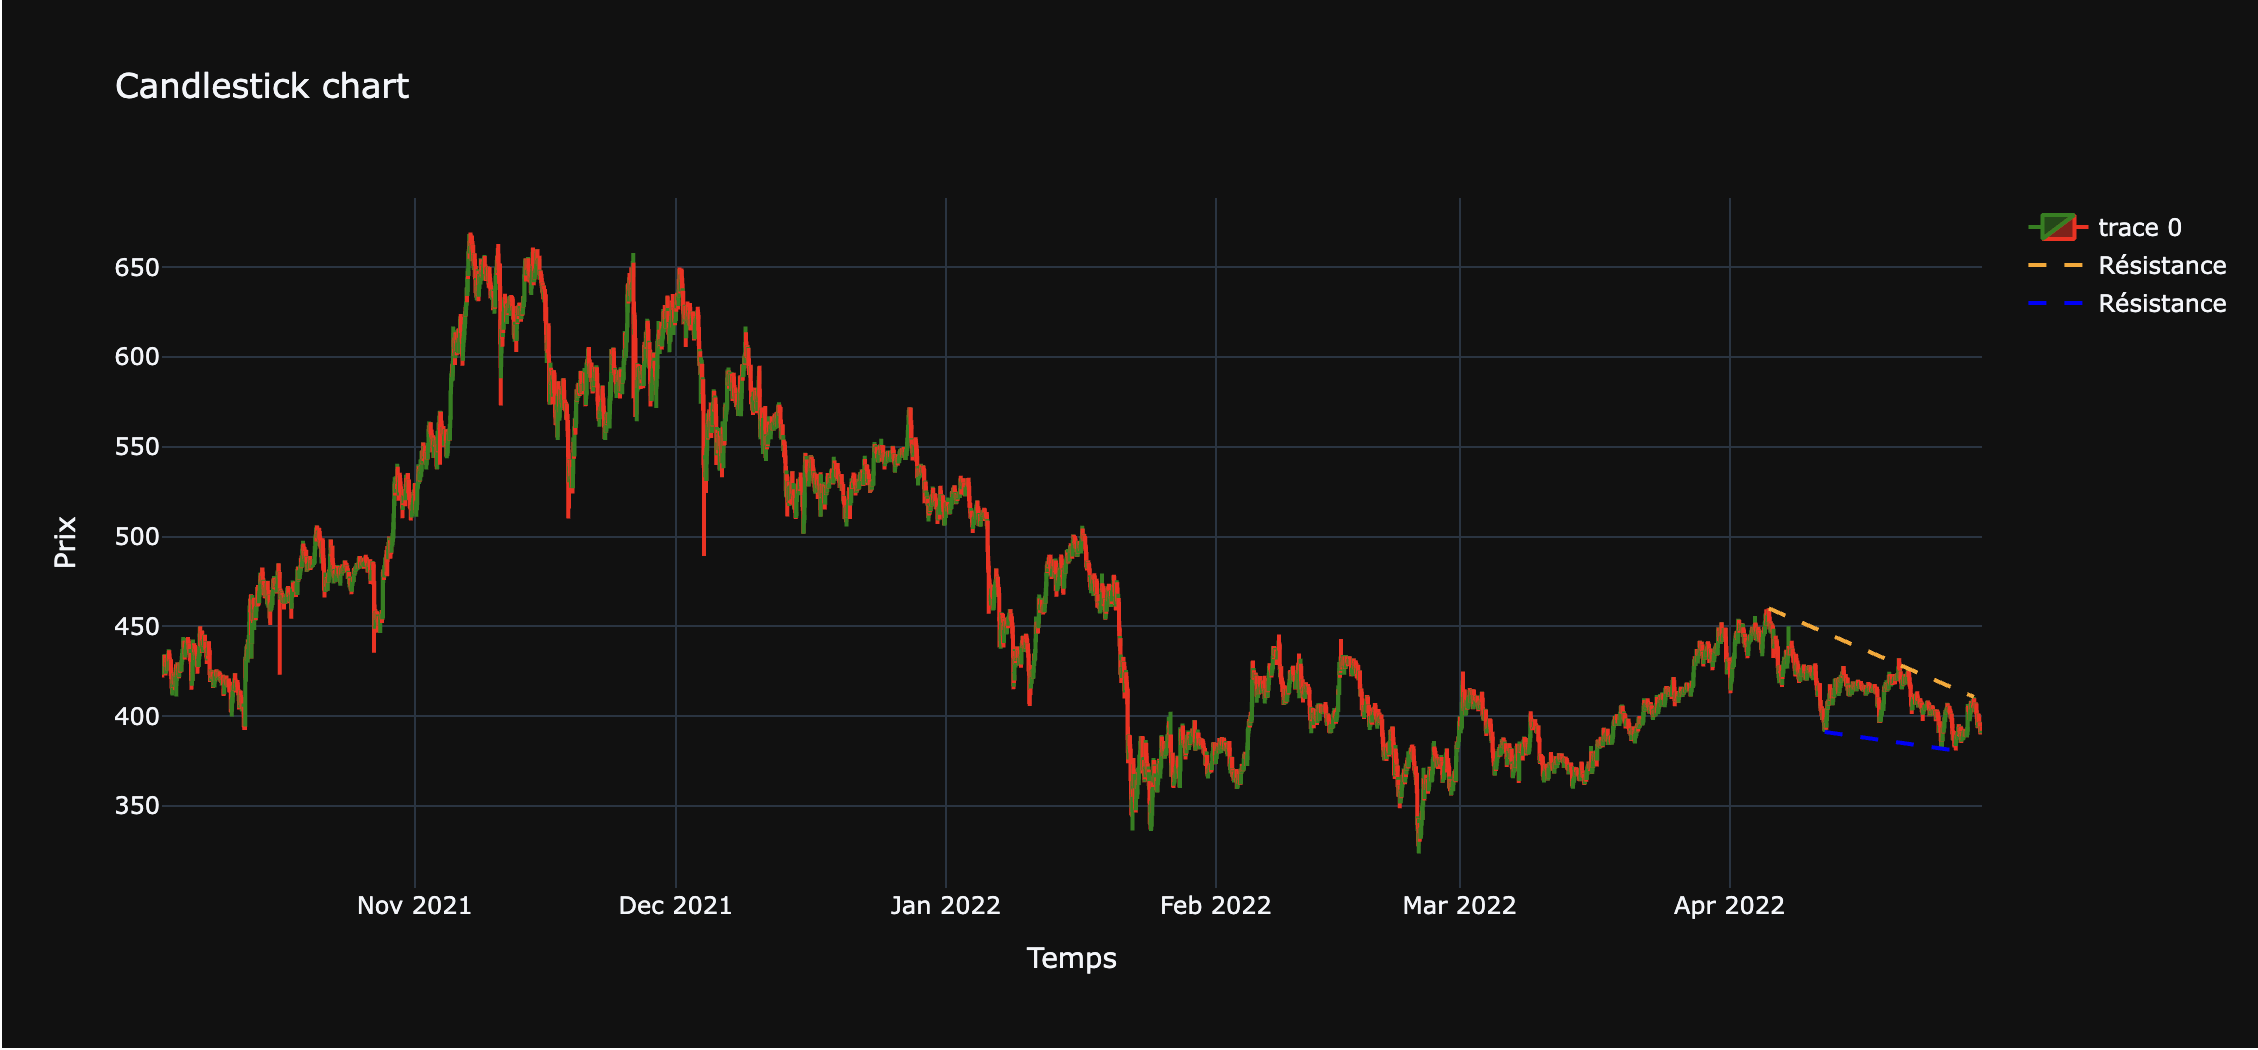

In [42]:
display(Image(filename="Last_trend.jpeg"))

#### Zoom on the Last Trend

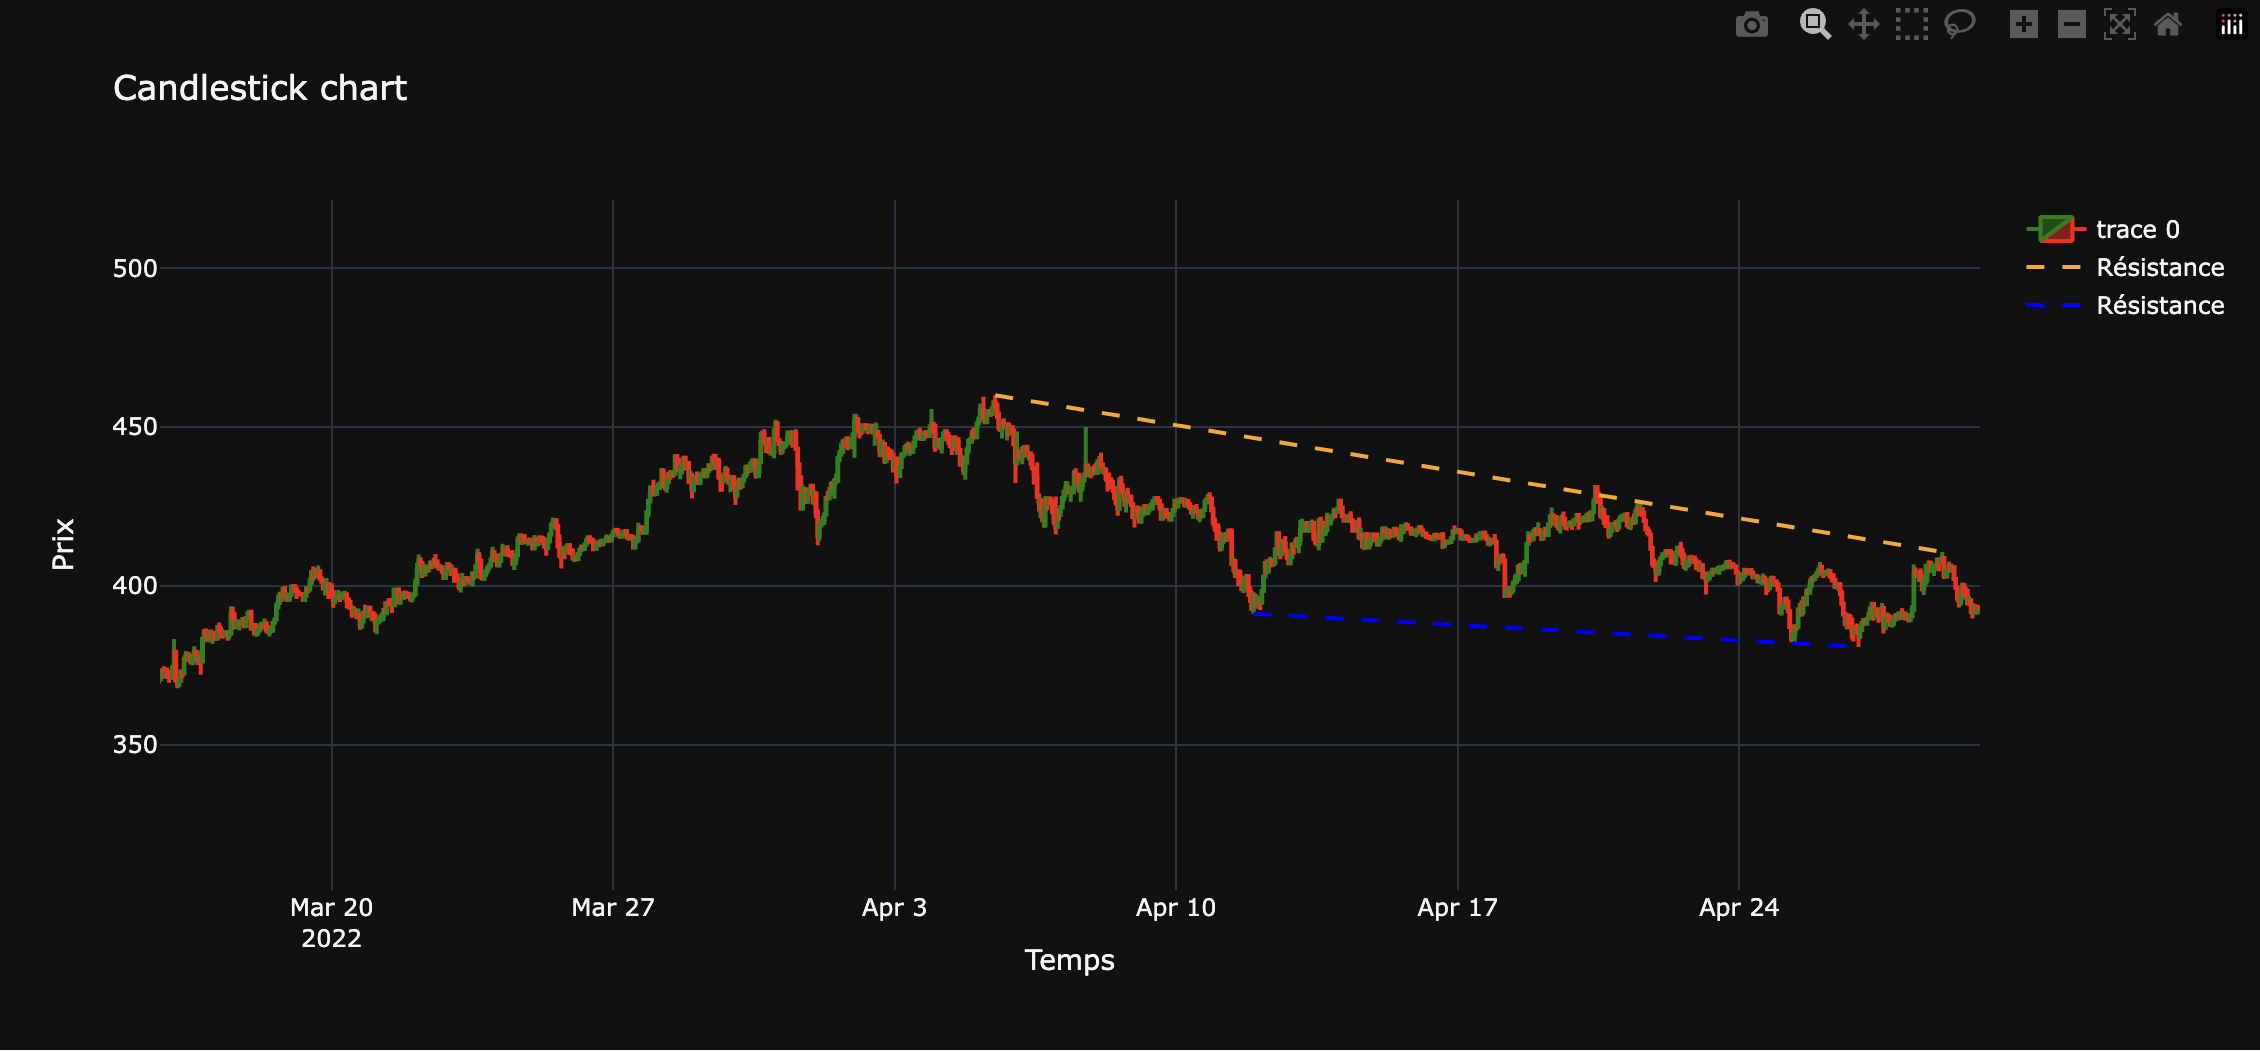

In [43]:
display(Image(filename="Zoom_sur_la_zone.jpeg"))

## III. Psychological level detection

### Exploration 1: 
-  We draw a constant and measure each time how many points cut it, we proceed in this way on all the possible prices of the chosen frame, and then we compare the results with each other and keep the straight line or the n straight lines with the most points. 

In [14]:
def find_pyscho (df, cutting=100) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}
    # Pour chaque niveau de prix dans l'intervalle [min_price, max_price], on compte le nombre de bougies traversant ce niveau.
    for val in np.linspace(min_price, max_price, cutting) : 
        count=df[(df['low']<=val) & (df['high']>=val)].shape[0]
        result[val] = count
    
    return result

In [15]:
#récupération du dictionnaire contenant les n-best threshold

psycho_threshold=find_pyscho(BNB_USDT_zoom_week,20)
best_psycho_threshold=sorted(psycho_threshold.items(), key=lambda x: -x[1])[:4]
best_psycho_threshold

[(414.5, 179), (432.7, 132), (396.3, 128), (378.1, 125)]

In [54]:
#plot_trend(BNB_USDT_zoom_week, best_psycho_threshold)

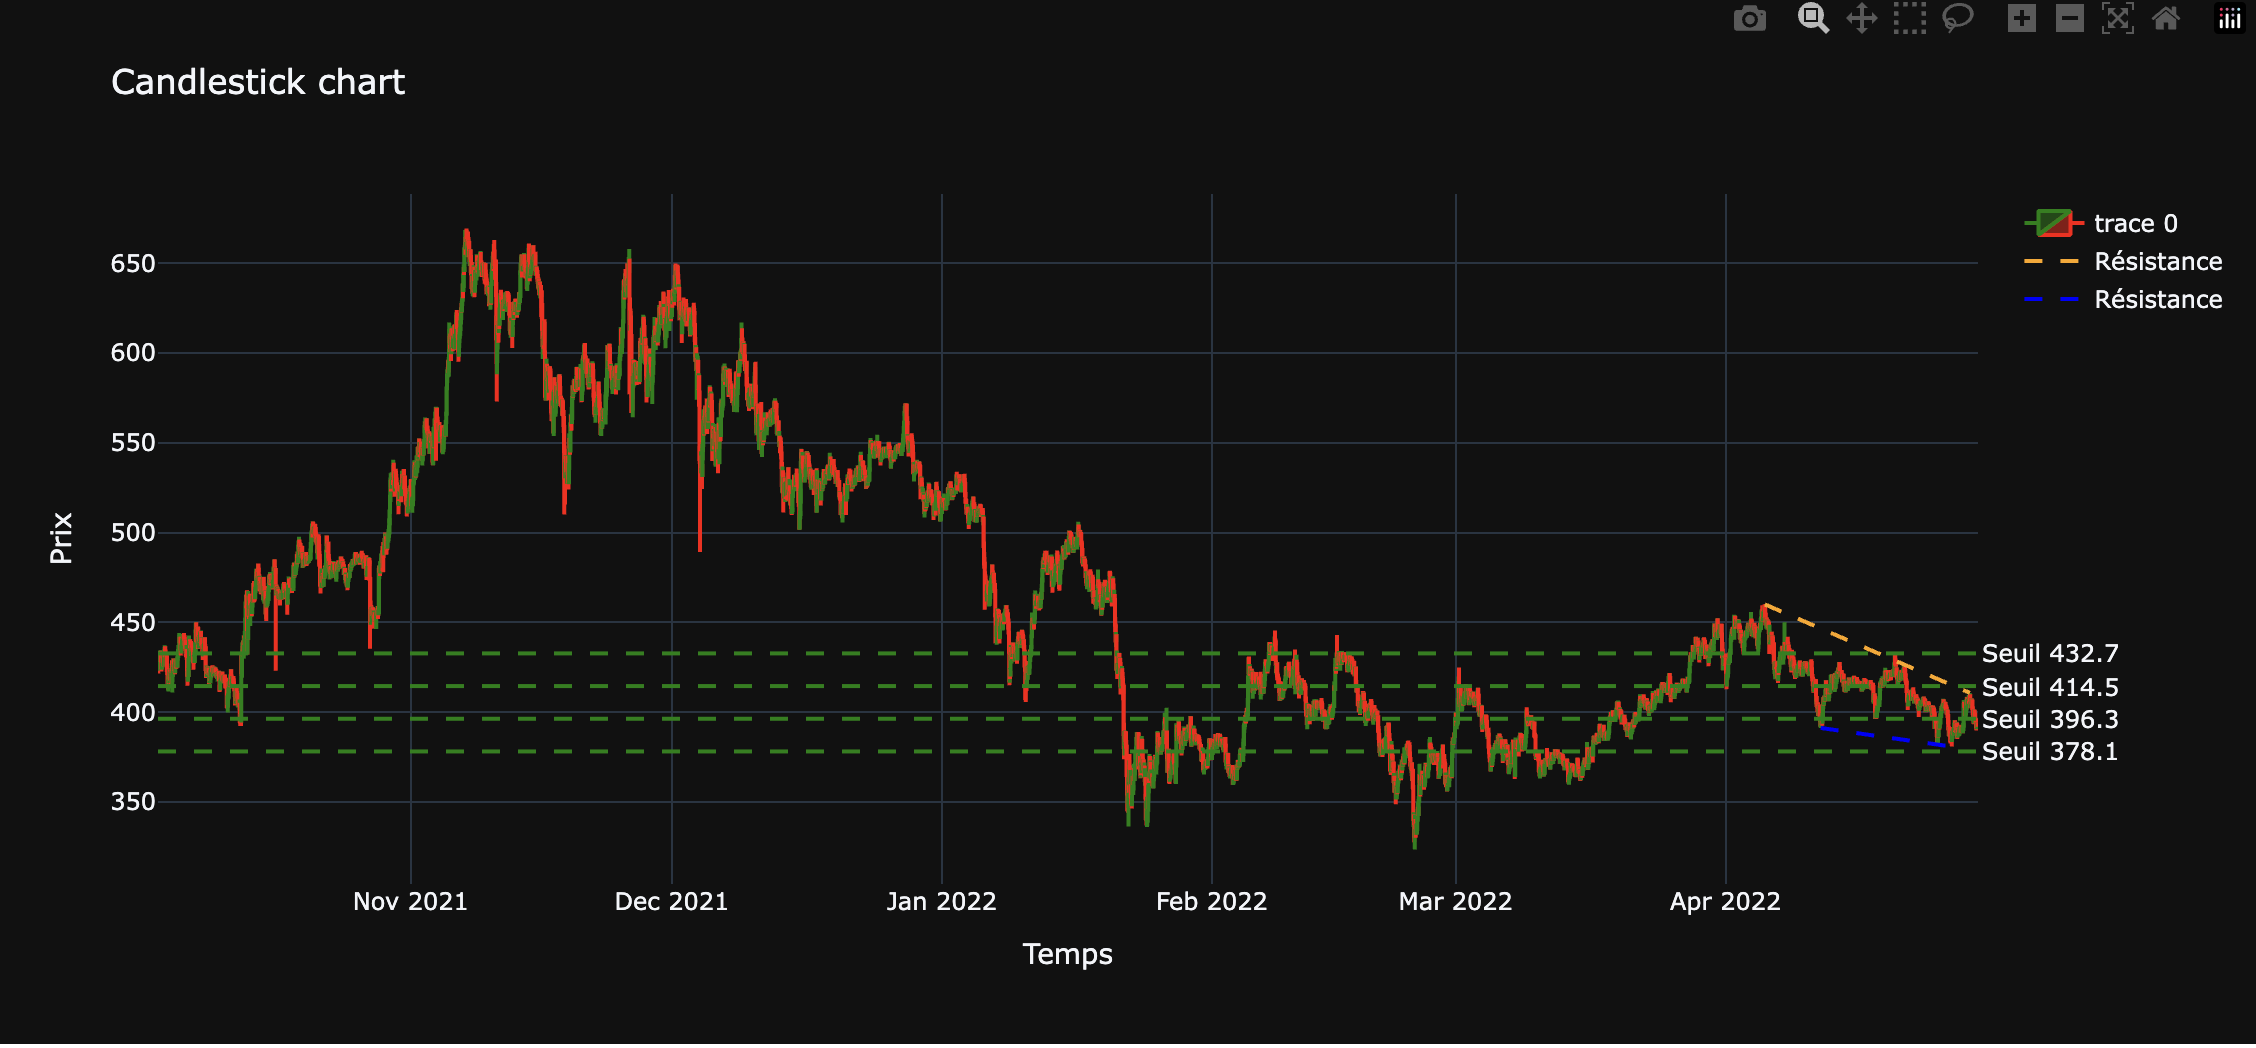

In [39]:
display(Image(filename="Exploration 1.jpeg"))

### Exploration 2: 
- We draw a constant and measure each time how many “candles rest” on the threshold, we proceed in this way on all the possible prices of the chosen frame, and then we compare the results with each other and keep the straight line or the n straight lines with the most candles according to a certain threshold. 

In [17]:
def find_pyscho_v2 (df, nb_seuil, cutting=100, tolerance=0.00005) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}
    for val in np.linspace(min_price, max_price, cutting) : 
        abs_tolerance = val * tolerance
        count = df[((df['high'] >= val - abs_tolerance) & (df['high'] <= val + abs_tolerance)) |
                   ((df['low'] >= val - abs_tolerance) & (df['low'] <= val + abs_tolerance))].shape[0]
        result[val] = count
    
    filtered_thresholds = {k: v for k, v in result.items() if v >= 3}

    best_psycho_threshold=sorted(filtered_thresholds.items(), key=lambda x: -x[1])[:nb_seuil]
    
    
    return best_psycho_threshold

In [53]:
#plot_trend(BNB_USDT_zoom_week, find_pyscho_v2(BNB_USDT_zoom_week,4, 100))

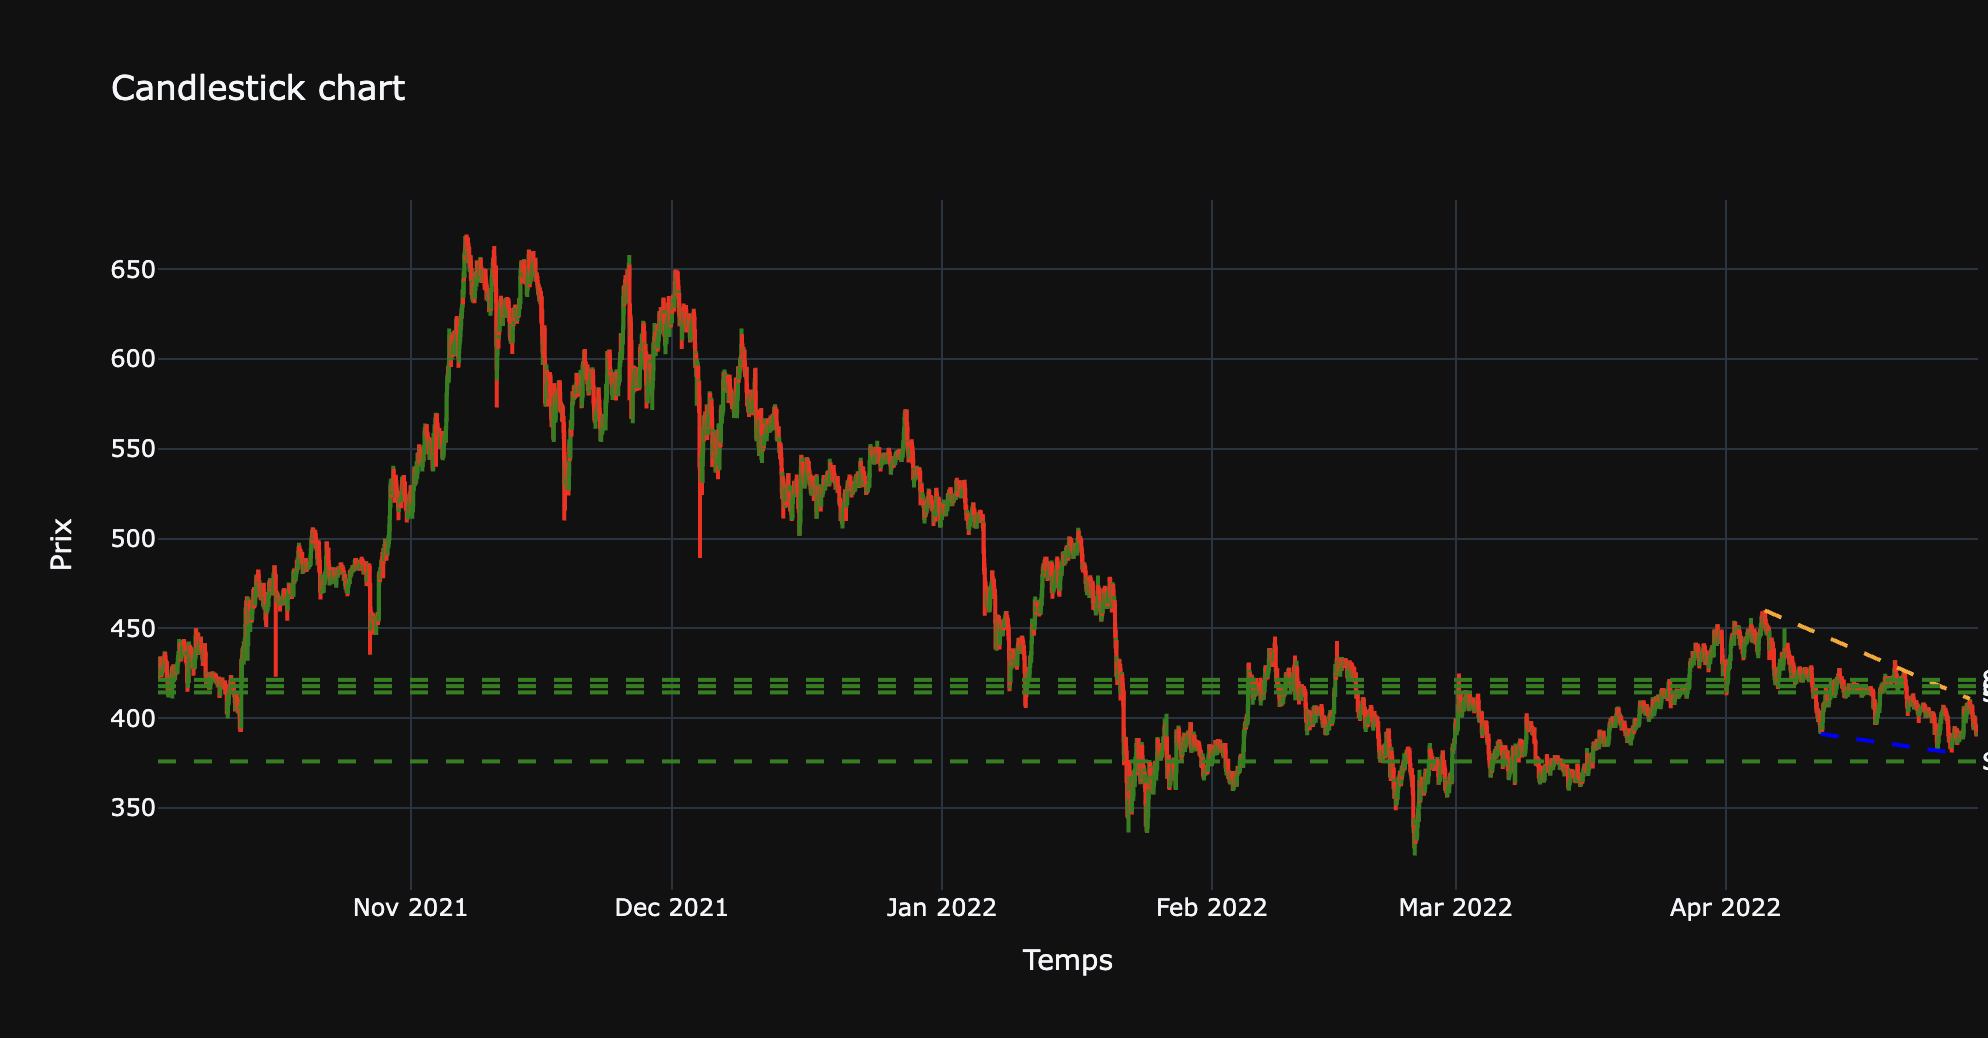

In [52]:
display(Image(filename="Exploration 2.jpeg"))

### Exploration 3: 
- We draw a constant and measure each time how many “candles rest” on the threshold, we proceed in this way on the set of possible prices of the chosen frame, according to a certain step we keep the best candidate between each step, and we then compare the results between them and keep the straight line or the n straight lines with the most candles.  

In [19]:
import builtins

def find_pyscho_v3 (df, nb_seuil, cutting=100, tolerance=0.001) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}

    variance_high = df['high'].var()
    variance_low = df['low'].var()
    variance_total = variance_high + variance_low

    # Définition du "pas" basé sur la racine carrée de la variance totale
    pas = np.sqrt(variance_total)

    for val in np.linspace(min_price, max_price, cutting) : 
        abs_tolerance = val * tolerance
        count = df[((df['high'] >= val - abs_tolerance) & (df['high'] <= val + abs_tolerance)) |
                   ((df['low'] >= val - abs_tolerance) & (df['low'] <= val + abs_tolerance))].shape[0]
        result[val] = count
    
    filtered_thresholds = {k: v for k, v in result.items() if v >= 3}
    current_interval_start = min_price
    selected_thresholds = []

    while current_interval_start <= max_price:
        current_interval_end = current_interval_start + pas
        # Filtrer les constantes dans l'intervalle actuel
        candidates = [(val, count) for val, count in filtered_thresholds.items()
                      if current_interval_start <= val < current_interval_end]
        if candidates:
            # Sélectionner la constante avec le meilleur score dans l'intervalle
            best_candidate = builtins.max(candidates, key=lambda x: x[1])
            selected_thresholds.append(best_candidate)
            # Retirer les candidats sélectionnés pour éviter les doublons
            for candidate in candidates:
                filtered_thresholds.pop(candidate[0], None)
        # Passer à l'intervalle suivant"
        current_interval_start = current_interval_end

    best_psycho_threshold = sorted(selected_thresholds, key=lambda x: x[1], reverse=True)[:nb_seuil]
    
    return best_psycho_threshold

In [50]:
#plot_trend(BNB_USDT_zoom_week, find_pyscho_v3(BNB_USDT_zoom_week,10, 15000))

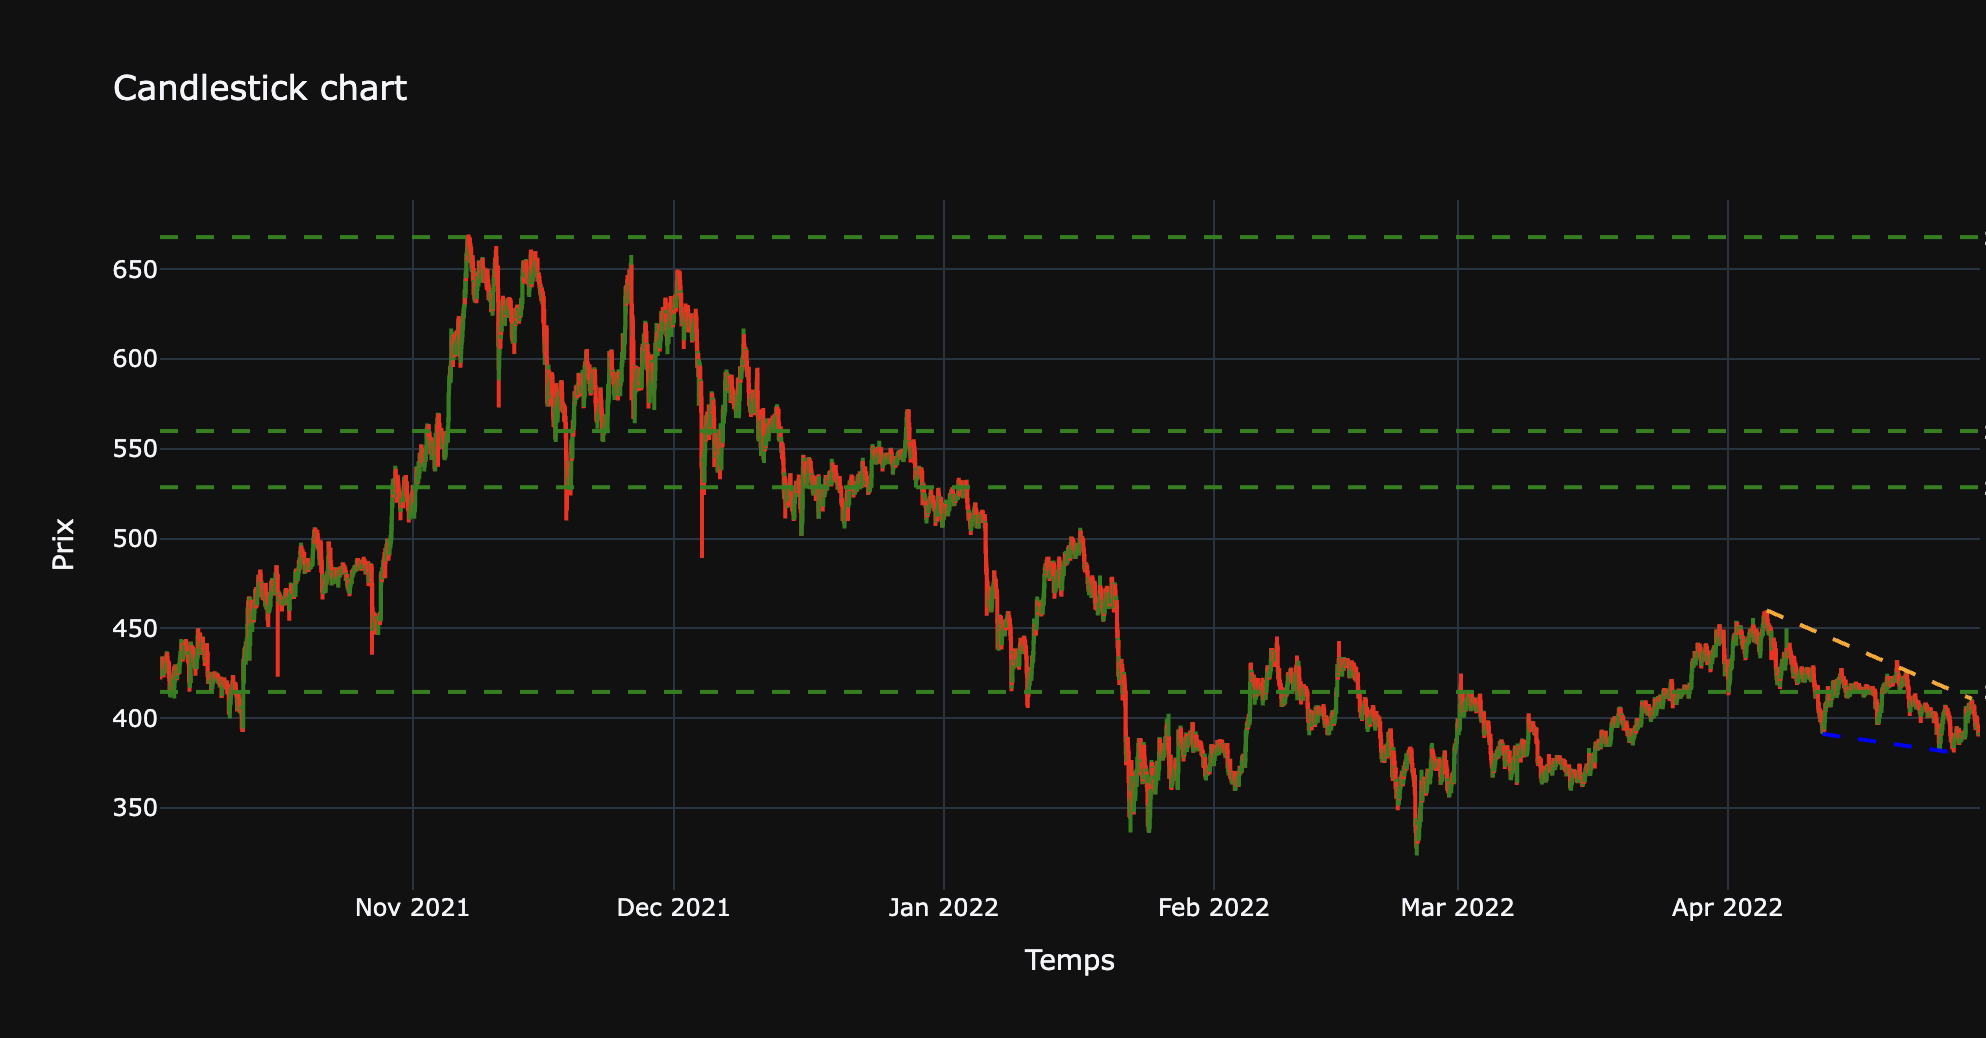

In [45]:
display(Image(filename="Exploration 3.jpeg"))

## VI. Global Trend

### Methodology: 
-  Determine peaks according to the prominence required 
-  Identify a pair of peaks 
-  Establish a slope and an intercept on this pair 
-  Calculate the noise between each peak and the defined line
-  Iterate for each pair of peaks and compare score 
-  Ditto for support (Determine “- peaks”)
-  Implement support and resistance in the data set for Data Visualization 

#### Visualization of the “peaks” identified during the various stages

In [49]:
variance_high = BNB_USDT_zoom_week['high'].var()
variance_low = BNB_USDT_zoom_week['low'].var()
variance_total = variance_high + variance_low
pas = np.sqrt(variance_total) # Pour chaque niveau de prix dans l'intervalle [min_price, max_price], on compte le nombre de bougies traversant ce niveau.

max_peaks, _ = find_peaks(BNB_USDT_zoom_week['high'], prominence=pas*0.3)
min_peaks, _ = find_peaks(-BNB_USDT_zoom_week['low'], prominence=pas*0.3)
#plot_trend(BNB_USDT_zoom_week, max_peak=max_peaks)

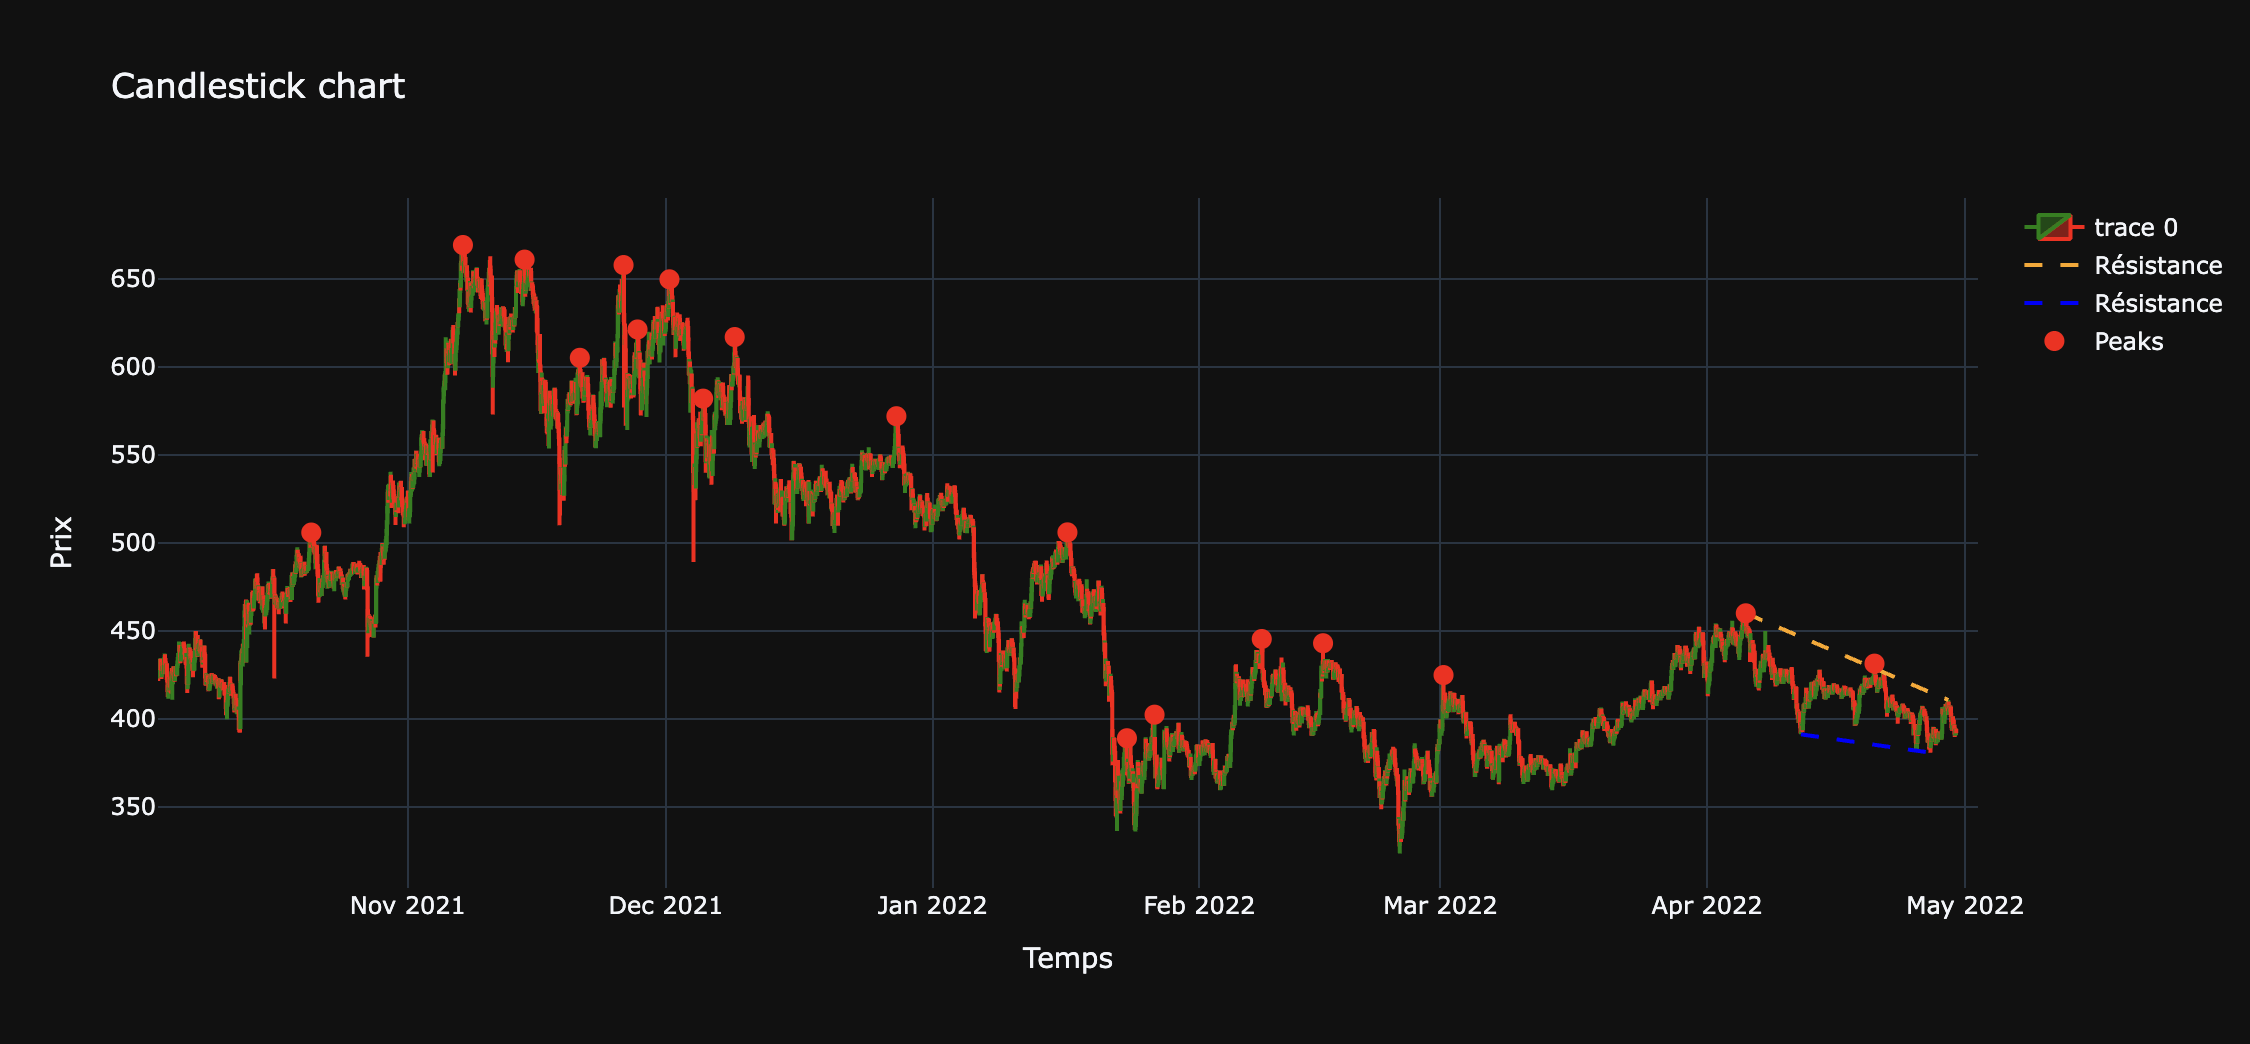

In [46]:
display(Image(filename="illustration des peak.jpeg"))

## Definition of Global Trend:

- score_resistance: Evaluates the quality of a resistance line according to its proximity and the number of touches with high points.
- score_support: Evaluates the quality of a support line according to its proximity and the number of touches with low points.
- test_resistance_glob: Calculates a global resistance between two vertices and returns either the line or a validity score, depending on the mode.
- test_support_glob: Calculates a global support between two troughs and returns either the line or a validity score depending on the mode.
- global_trend :   Detects the most relevant global resistance and support from local price peaks.

In [22]:
def score_resistance (resist, data_, min_touch_dist=0.001) :

    # Initialization of score, tolerance and number of “touches"
    score_test=0
    tol=0.01
    score_test = 0
    touches = 0
    n = len(data_)

    for i in range(n):  # Loop over each point in the data series

        if data_[i] != 0:
            diff = data_[i] - resist[i] # Deviation between actual data and resistance


            if diff > resist[i] * tol:  # If data significantly exceeds resistance, it is considered invalid → very low score

                return -np.inf

            if abs(diff) <= min_touch_dist:
                touches += 1

            score_test += 1 / (1 + abs(diff)) # Increment the score: the closer the point is to the resistance, the greater its contribution.
 
    touch_bonus = 1 + touches / n       # Bonus proportional to the number of touches

    # Final score is amplified by trend length
    return score_test  * touch_bonus *(n**2)
    

def score_support (support, data_, min_touch_dist=0.001) :

    score_test = 0
    tol = 0.01
    touches = 0
    n = len(data_)

    for i in range(n):
        if data_[i] != 0:
            diff = support[i] - data_[i]  # inversion ici

            if diff > support[i] * tol:
                return -np.inf  # trop en dessous du support

            if abs(diff) <= min_touch_dist:
                touches += 1

            score_test += 1 / (1 + abs(diff))

    touch_bonus = 1 + touches / n
    return score_test * touch_bonus * (n ** 2)

'''
score_test=0
tol=0.01
for i in range(len(support)) :
    if data_[i] !=0 :
        if data_[i] < support[i] * (1 - tol):
            return -np.inf  # cassure par le haut => invalide
        else:
            score_test += 1 / (1 + abs(support[i] - data_[i]))  
return score_test
'''

def test_resistance_glob (y1, start, y2, end, df, max_peaks, first=None, last=None, find=None) :

    # Calculates the parameters (slope a and y-intercept b) of the line passing through two given points: (start, y1) and (end, y2)
    a, b =calc_line_params(start, y1, end, y2)
    resistance_glob= np.zeros(df.shape[0])
    x_range = np.arange(start, end + 1)
    resistance_glob[start:end + 1] = a * x_range + b

    if find is not None: # If you are in “find” mode, you only want to return the constructed line without scoring.
        return resistance_glob 
    
    benchmark= np.zeros(df.shape[0])
    for i in range(first,last+1) :      # Alternatively, prepare a benchmark vector based on real high points (max_peaks)
        benchmark[max_peaks[i]]= df['high'].iloc[max_peaks[i]]

    # Returns the score of the line by comparing the values of the line with the true price peaks
    return score_resistance(resistance_glob[start:end + 1], benchmark[start:end + 1])

def test_support_glob (y1, start, y2, end, df, min_peaks, first=None, last=None, find=None) :

    a, b =calc_line_params(start, y1, end, y2)
    support_glob= np.zeros(df.shape[0])
    x_range = np.arange(start, end + 1)
    support_glob[start:end + 1] = a * x_range + b

    if find is not None: 
        return support_glob 
    
    benchmark= np.zeros(df.shape[0])
    for i in range(first,last+1) :
        benchmark[min_peaks[i]]= df['low'].iloc[min_peaks[i]]

    return score_support(support_glob[start:end + 1], benchmark[start:end + 1])
    
def global_trend (df, learning_rate) : 

    # Step 1: Calculate “volatility” (variance) to determine an adaptive detection threshold
    variance_high = df['high'].var()
    variance_low = df['low'].var()
    variance_total = variance_high + variance_low
    pas = np.sqrt(variance_total)

    # Step 2: Detect peaks and troughs in the 'high' and 'low' columns
    max_peaks, _ = find_peaks(df['high'], prominence=pas*learning_rate)
    min_peaks, _ = find_peaks(-df['low'], prominence=pas*learning_rate)

    # Step 3: Check that there are enough peaks to build significant lines
    if len(max_peaks) < 2:
        raise ValueError("Pas assez de pics pour détecter une résistance globale.")

    if len(min_peaks) < 2:
       raise ValueError("Pas assez de pics pour détecter un support global.")

     # Step 4: Setting the best scores for resistance and support
    score_resistance={
        "score": -np.inf, 
        "First_peak" : 0,
        "Last_peak" : 0
        }
    
    score_support={
        "score":-np.inf, 
        "First_peak" : 0,
        "Last_peak" : 0
        }
    
    # Step 5: Loop through all vertex pairs to find the best resistance line
    for i in range(len(max_peaks)) :
        for peak in range(i+1, max_peaks.shape[0] ): 
            tmp=test_resistance_glob(df['high'].iloc[max_peaks[i]], max_peaks[i],  df['high'].iloc[max_peaks[peak]], max_peaks[peak], df, max_peaks, i, peak)
            if tmp>score_resistance["score"]:
                score_resistance["score"] = tmp
                score_resistance["First_peak"]= max_peaks[i]
                score_resistance["Last_peak"]= max_peaks[peak]

    # Ditto for troughs - we're looking for the best support line
    for i in range(len(min_peaks)):
        for peak in range(i+1, min_peaks.shape[0] ): 
            tmp=test_support_glob(df['low'].iloc[min_peaks[i]], min_peaks[i],  df['low'].iloc[min_peaks[peak]], min_peaks[peak], df, min_peaks, i, peak)
            if tmp>score_support["score"]:
                score_support["score"]=tmp
                score_support["First_peak"]= min_peaks[i]
                score_support["Last_peak"]= min_peaks[peak]
    
    # Step 7: Final construction of optimal lines (resistance and support) from selected peaks
    resistance_globale=test_resistance_glob(df['high'].iloc[score_resistance["First_peak"]], 
                                            score_resistance["First_peak"], 
                                            df['high'].iloc[score_resistance["Last_peak"]], 
                                            score_resistance["Last_peak"], 
                                            df, max_peaks, find=True)

    support_globale=test_support_glob(df['low'].iloc[score_support["First_peak"]], 
                                      score_support["First_peak"],  
                                      df['low'].iloc[score_support["Last_peak"]], 
                                      score_support["Last_peak"], 
                                      df, min_peaks, find=True)

    return resistance_globale, support_globale

In [23]:
resistance_global, support_global=global_trend(BNB_USDT_zoom_week, 0.15)

#### Implementation of the global trend in the data set for datavisualization 

In [24]:
BNB_USDT_zoom_week['resistance_global']=resistance_global
BNB_USDT_zoom_week['resistance_global']=BNB_USDT_zoom_week['resistance_global'].replace(0.0, np.nan)

BNB_USDT_zoom_week['support_global']=support_global
BNB_USDT_zoom_week['support_global']=BNB_USDT_zoom_week['support_global'].replace(0.0, np.nan)

#### Redefinition of chart and indicator implementation

In [25]:
def plot_trend_v2 (df, threshold=None, title="Candlestick chart"):
   
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['resistance'],
        mode='lines',
        line=dict(color='rgba(255, 220, 100, 1)'),
        name='Résistance'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['support'],
        mode='lines',
        line=dict(color='rgba(255, 220, 100, 1)'),
        name='Résistance'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['support_global'],
        mode='lines',
        line=dict(color='red'),
        name='Support'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['resistance_global'],
        mode='lines',
        line=dict(color='red'),
        name='Résistance'
    ))

    if threshold!=None :
        for seuil in threshold :
            fig.add_hline(y=seuil[0], line=dict(color='#7FDBFF', dash='dash'), opacity=0.6, annotation_text=f'Seuil {seuil[0]}', annotation_position='right')
    fig.show()

In [48]:
#plot_trend_v2(BNB_USDT_zoom_week, find_pyscho_v3(BNB_USDT_zoom_week,10, 15000))

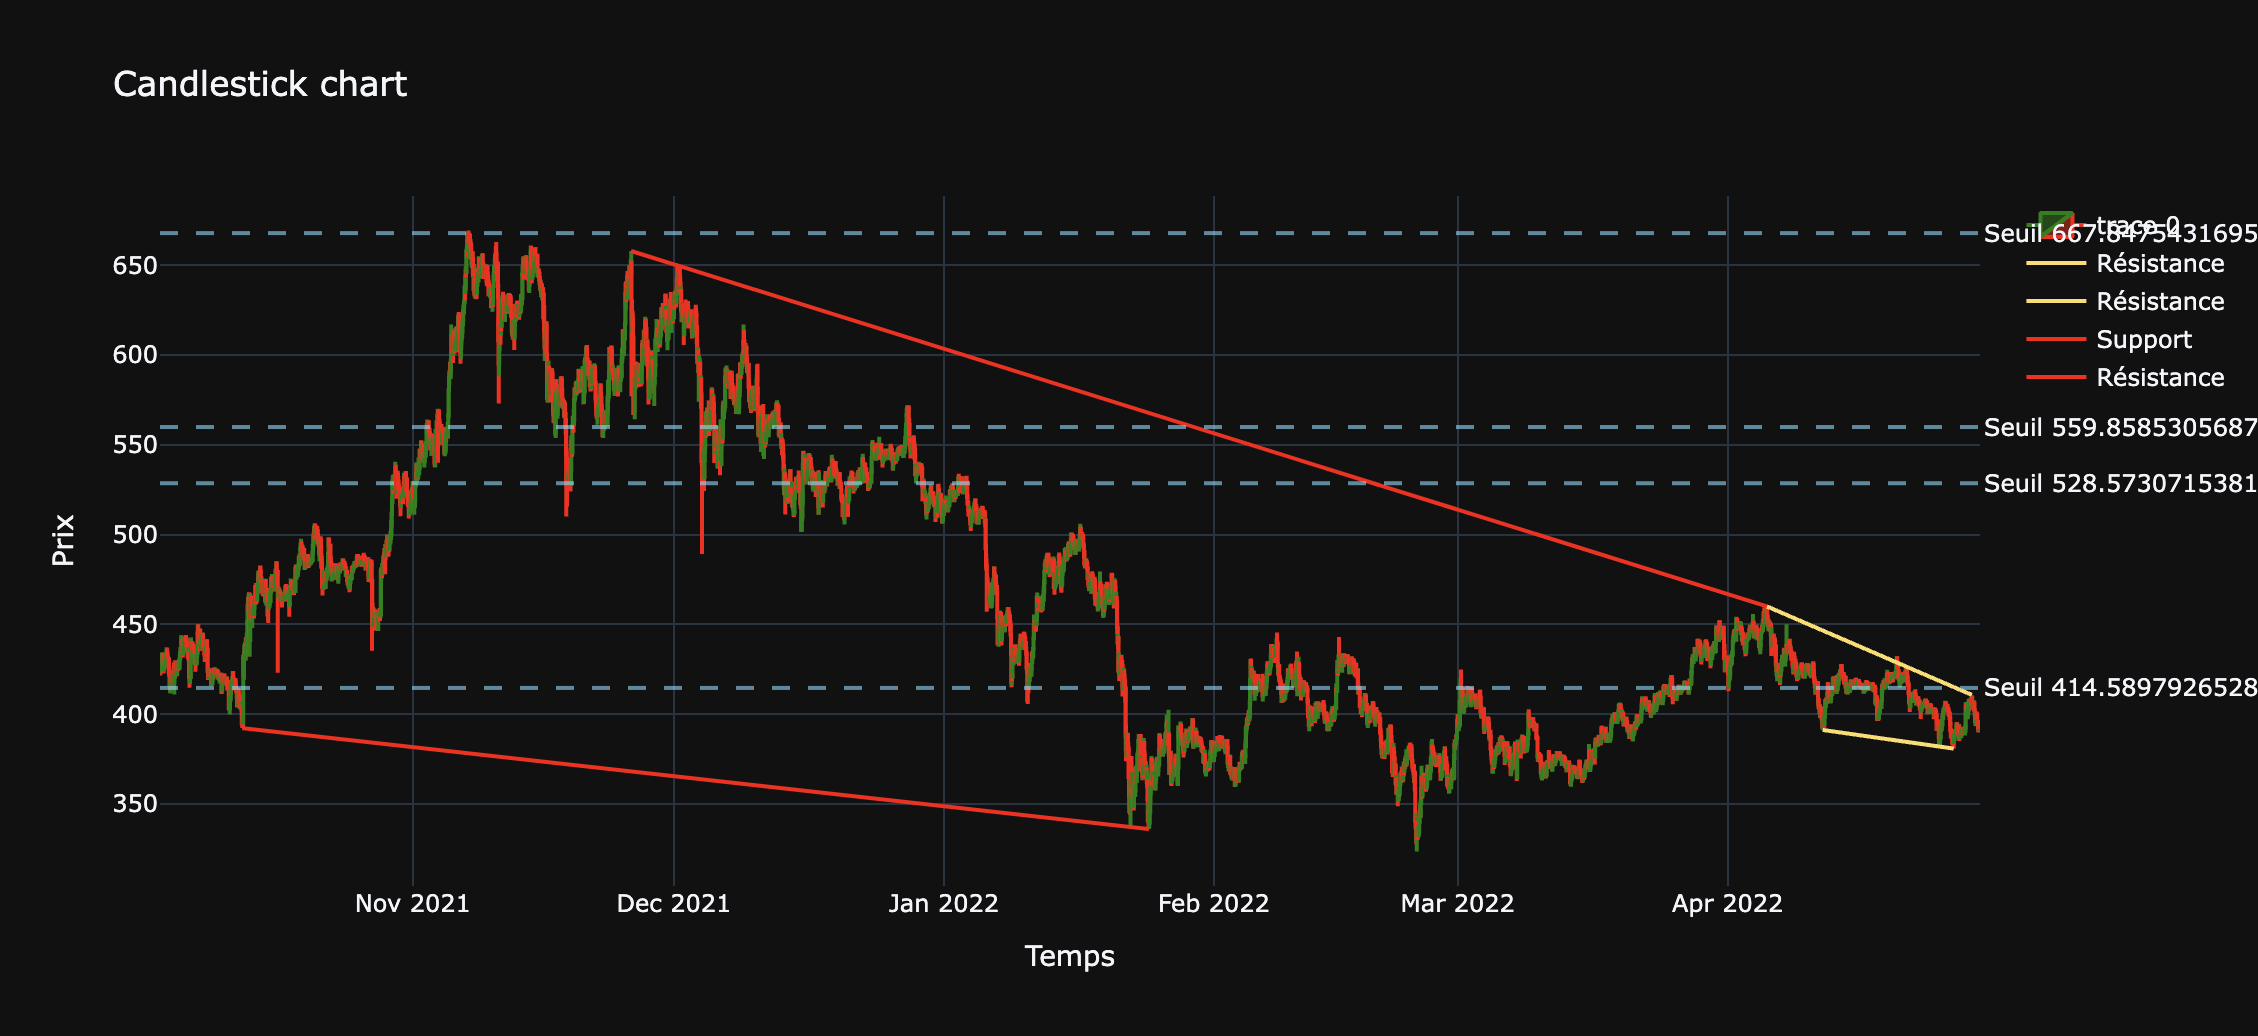

In [47]:
display(Image(filename="final.jpeg"))

## Conclusion 

- ### We have been able to identify the gloable trend in red 

- ### We have been able to identify an "internal" trend operating on a shorter peridoe

- ### We have been able to identify psychological price thresholds based on the past.

## Vimal Dhama